In [172]:
from SPARQLWrapper import SPARQLWrapper, JSON, N3
import rdflib
from IPython.display import Image
from pprint import pprint

# The Pathogen's Accomplice

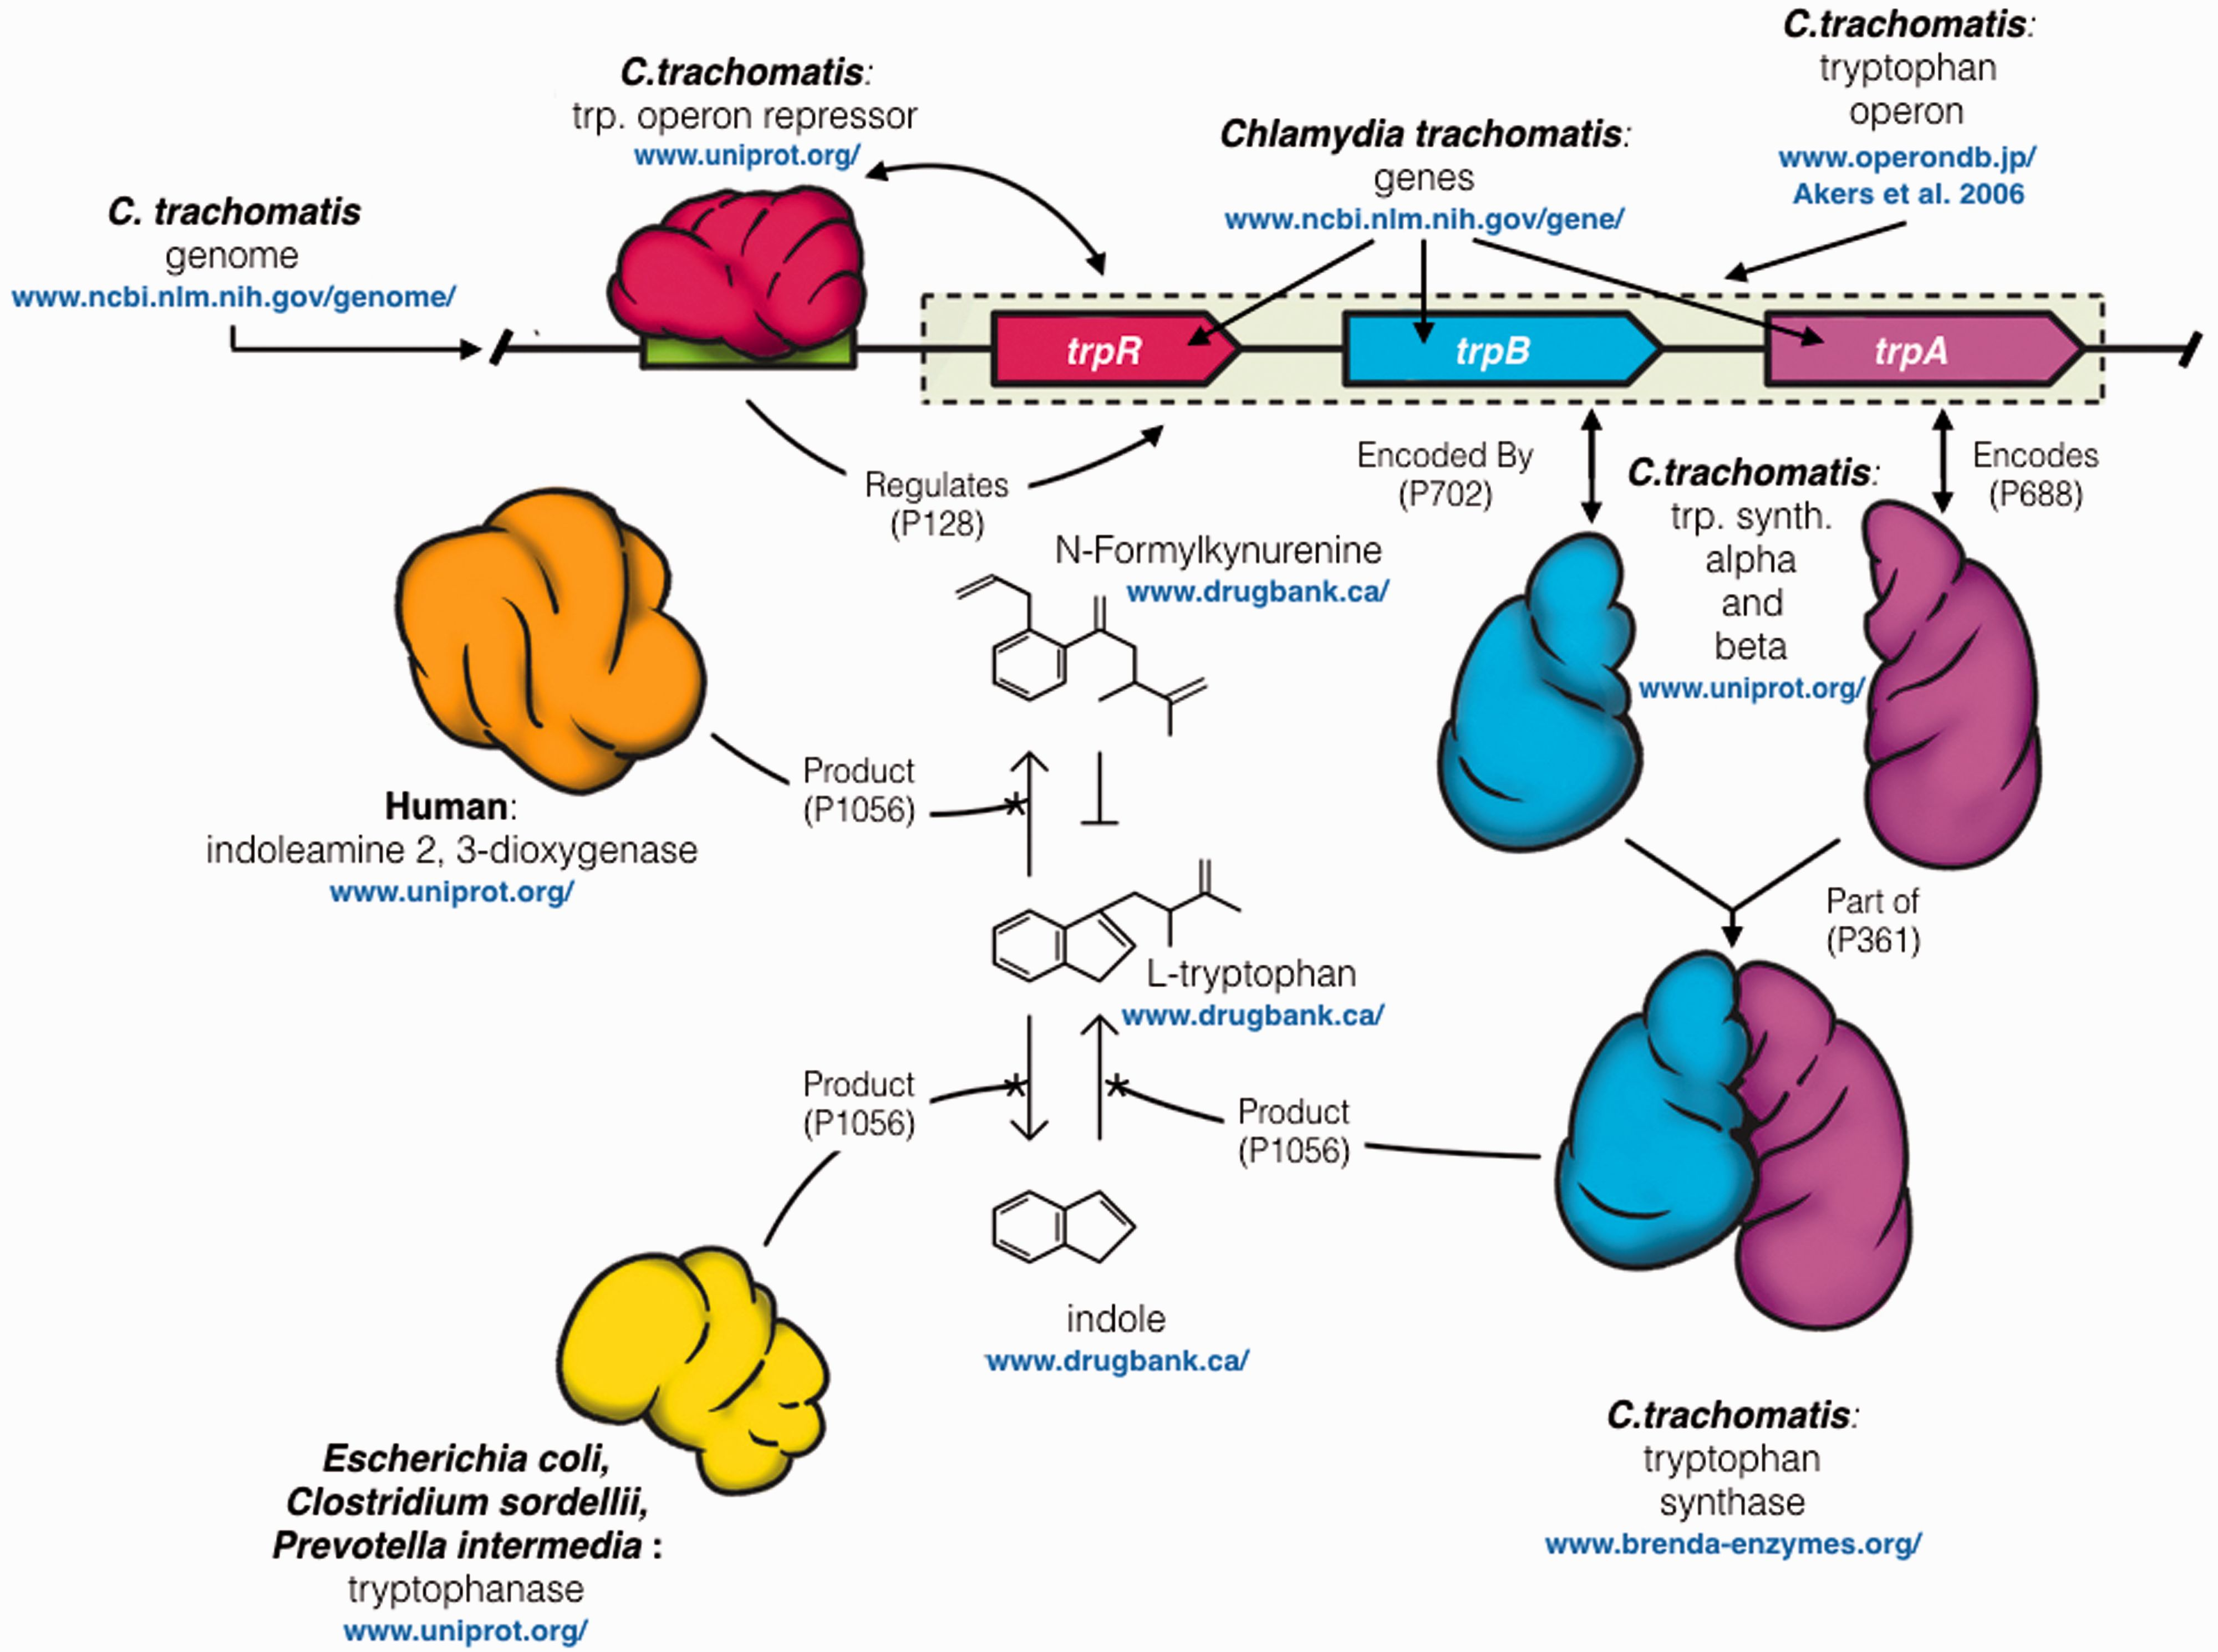

In [152]:
Image("img/chlam.jpeg")

# Question:  what other bacteria might be present in the host microbiome that could be supplying this endogenous Indole

# Given the chemical of interest, 
### - what reactions are capable of producing that chemical, 
### - what enzymes catalyze that reaction, 
### - what proteins have that enzymatic activity
### - what organisms express that protein

# RDF Model

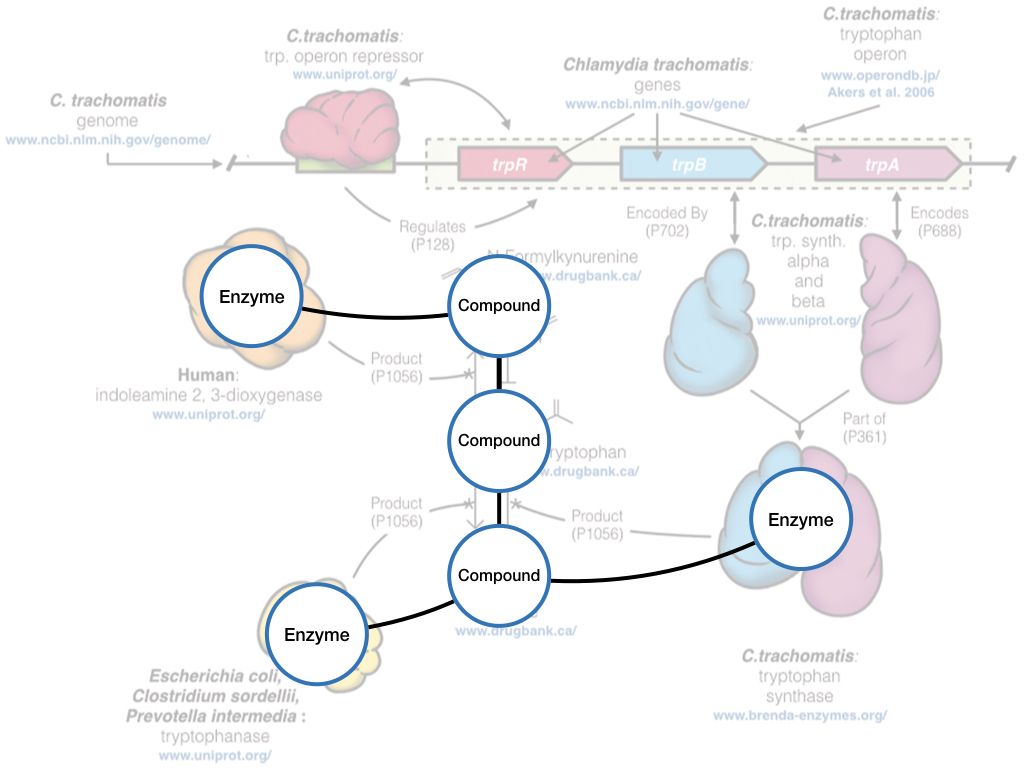

In [153]:
Image("img/SimpleModel/SimpleModel.001.jpeg")

## Unsuitable modeling for this use case.  Simple triples can't do it. Refied nodes are neccessary to model the concept of a reaction itself.

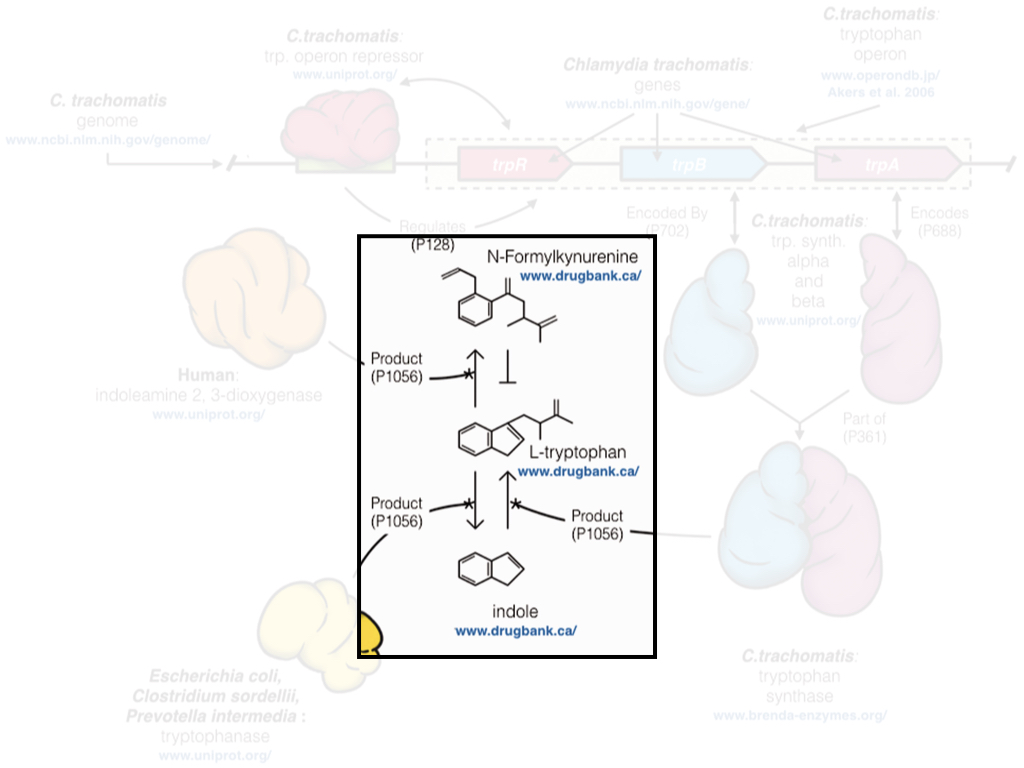

In [166]:
Image('img/Reified/Reified.001.jpeg')

## Federated SPARQL Query through multiple namespaces

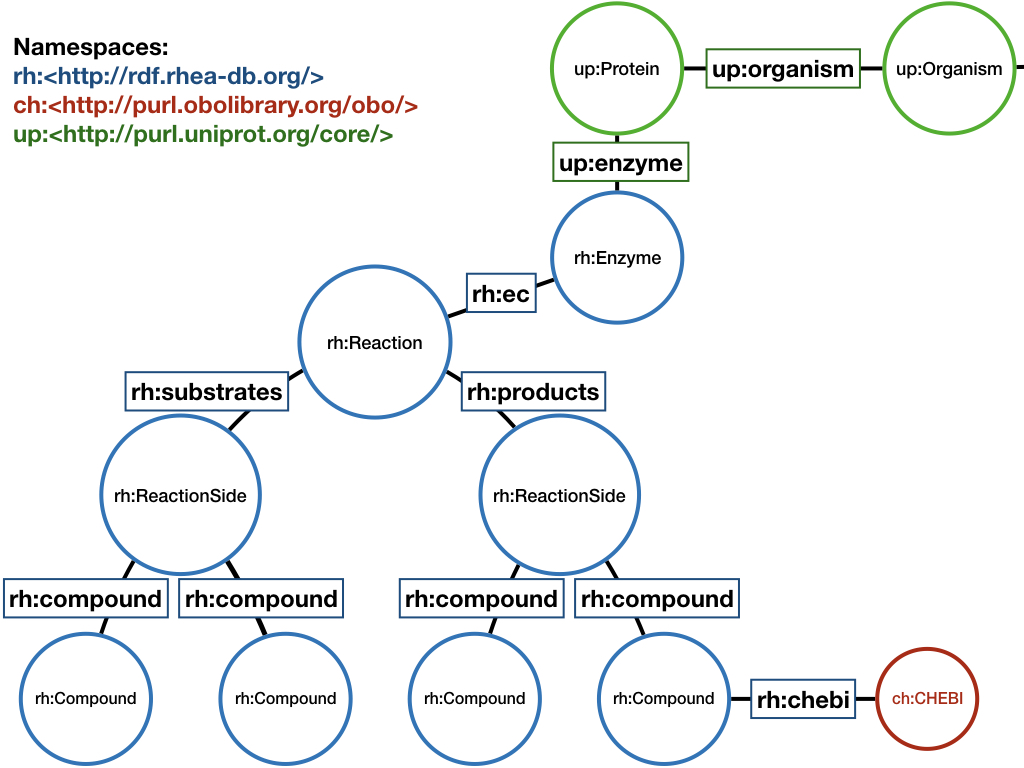

In [167]:
Image('img/Reified/Reified.002.jpeg')

### The entry point, a ChEBI curie (compact URI)

In [3]:
indole = 'CHEBI:35581'

In [160]:
def execute_query(query:str, fmt:object, endpoint:str) -> dict:
    """
    execute any SPARQL query
    -params-
    query: sparql query
    fmt: return format
    endpoint: the endpoint to query
    -returns-
    a sparql return object with results in the 'bindings' 
    """
    endpoint = SPARQLWrapper(endpoint)
    endpoint.setQuery(query)
    endpoint.setReturnFormat(fmt)
    return endpoint.query().convert()

def chebi2reactions(chebi:str) -> dict:
    """
    given a chemical id, construct and return a graph that includes the 
    reactions that produce that produce that chemical and the different 
    organisms capable of catalyzing that reaction
    
    -params-
    chebi: a chebi curie in the format of CHEBI:xxxxx or CHEBI_xxxxx
    """
    query =     '''
        PREFIX rh:<http://rdf.rhea-db.org/>
        PREFIX xsd:<http://www.w3.org/2001/XMLSchema#>
        PREFIX rh:<http://rdf.rhea-db.org/>
        PREFIX ch:<http://purl.obolibrary.org/obo/>
        PREFIX up:<http://purl.uniprot.org/core/>
        PREFIX taxon:<http://purl.uniprot.org/taxonomy/> 
        CONSTRUCT {
                     ?reaction rh:produces ?chebiLabel;
                               rh:equation ?equation;
                               up:organism ?taxonName.
               
                }
        WHERE {
          ?reaction rdfs:subClassOf rh:DirectionalReaction;
                    rh:substrates ?substrates;
                    rh:products ?products;
                    rh:equation ?equation.
          ?master rh:directionalReaction ?reaction;
                  rh:ec ?enzyme.
          ?substrates rh:curatedOrder "1"^^xsd:long;
                      rh:contains ?subParticipant.
          ?products rh:curatedOrder "2"^^xsd:long;
                      rh:contains ?prodParticipant.
          ?prodParticipant rh:compound ?compound .
                  ?compound rh:chebi ?chebi .
                  ?chebi rdfs:subClassOf* ch:%s;
                         rdfs:label ?chebiLabel.
          SERVICE <http://sparql.uniprot.org/sparql> {
                ?protein a up:Protein;
                           up:enzyme ?enzyme;
                            up:organism ?species.
                ?taxon a up:Taxon;
                         up:scientificName ?taxonName;
                         rdfs:subClassOf taxon:2;
                         up:rank up:Genus.
                ?species up:rank up:Species;
                         rdfs:subClassOf ?taxon.
                   }
        }
        LIMIT 20
        ''' % chebi.replace(':', '_')
    return execute_query(query=query, fmt=N3, endpoint='https://sparql.rhea-db.org/sparql')



In [170]:
data = chebi2reactions(indole)

In [169]:
graph = rdflib.Graph()
graph.parse(data=data, format=N3)

<Graph identifier=Nd91aa2ac2142434880a1be7ff9d1f323 (<class 'rdflib.graph.Graph'>)>

In [163]:
import graphviz as gv

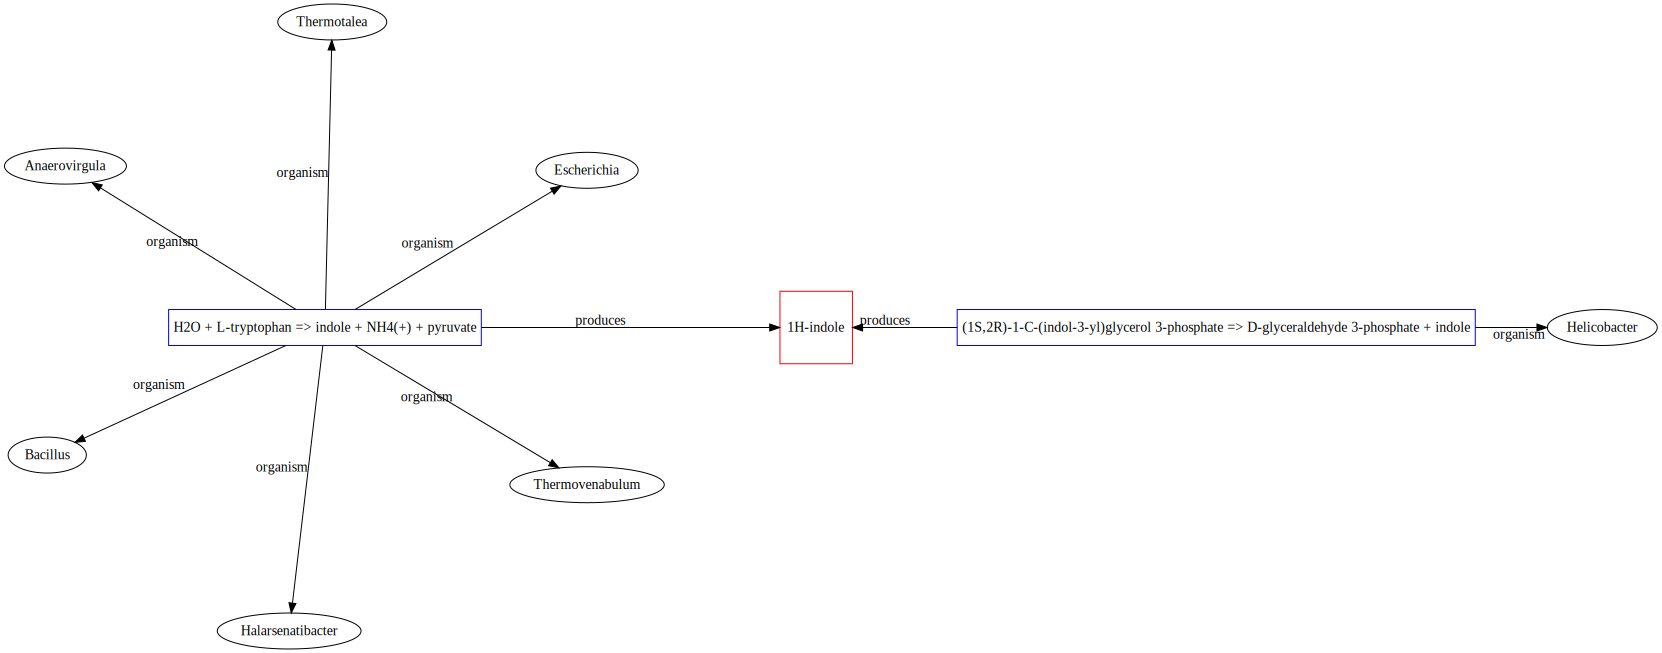

In [186]:
def strip_uri(uri):
    return uri.split('/')[-1]

graph_view = gv.Digraph(name='indole graph', strict=True, engine='circo')
graph_view.graph_attr['overlap'] = 'False'
for s, p, o in graph:
    if 'equation' in p:
        graph_view.node(strip_uri(s), label=o, color='blue', shape='box')
    elif 'produces' in p:
        graph_view.node(strip_uri(o), color='red', shape='square')
        graph_view.edge(strip_uri(s), strip_uri(o), label=strip_uri(p))
    else:  
        graph_view.node(strip_uri(o))
        graph_view.edge(strip_uri(s), strip_uri(o), label=(strip_uri(p)))

graph_view

## Keep Querying:
### - location in the body
### - pathogens or non-pathogens
### - drugs that treat